# Natural Language Processing with Deep Learning (7 points)

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [ ]:
!wget https://ysda-seminars.s3.eu-central-1.amazonaws.com/Train_rev1.zip

--2021-11-10 16:55:12--  https://ysda-seminars.s3.eu-central-1.amazonaws.com/Train_rev1.zip
Resolving ysda-seminars.s3.eu-central-1.amazonaws.com (ysda-seminars.s3.eu-central-1.amazonaws.com)... 52.219.47.148
Connecting to ysda-seminars.s3.eu-central-1.amazonaws.com (ysda-seminars.s3.eu-central-1.amazonaws.com)|52.219.47.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128356352 (122M) [application/zip]
Saving to: ‘Train_rev1.zip’

Train_rev1.zip      100%[===================>] 122.41M  25.4MB/s    in 5.6s    

2021-11-10 16:55:18 (21.7 MB/s) - ‘Train_rev1.zip’ saved [128356352/128356352]



In [ ]:
! unzip -e ./Train_rev1.zip

Archive:  ./Train_rev1.zip
  inflating: Train_rev1.csv          


In [ ]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
123898,69966069,Asbestos Analyst Essex / South East,Asbestos Analyst Essex and South East Our clie...,Essex,Essex,NaN,permanent,Penguin Recruitment,Engineering Jobs,"23000 - 26000/annum vehicle, paid overtime",24500,cv-library.co.uk,10.106469
84715,69078801,Class 2 driver,Longterm temporary assigment class 2 driver re...,"Cannock, West Midlands",Cannock,NaN,contract,Vebro,Engineering Jobs,7/hour,13440,cv-library.co.uk,9.506065
86446,69091779,Financial Accountant,Financial Accountant Client: My client is glob...,Belfast,Belfast,full_time,permanent,VanRath,Accounting & Finance Jobs,30000 - 40000,35000,nijobs.com,10.463132


(array([  714.,  1138., 18622., 42467., 68697., 65041., 33935., 12601.,
         1444.,   109.]),
 array([ 8.517393 ,  8.886262 ,  9.25513  ,  9.623999 ,  9.9928665,
        10.361735 , 10.730604 , 11.099472 , 11.468341 , 11.837209 ,
        12.206078 ], dtype=float32),
 <a list of 10 Patch objects>)

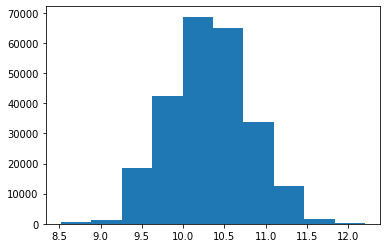

In [ ]:
plt.hist(data['Log1pSalary'])

### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [ ]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [ ]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [ ]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [ ]:
data['Title'].values

array(['engineering systems analyst', 'stress engineer glasgow',
       'modelling and simulation analyst', ..., 'english teacher',
       'supply teachers', 'accountant'], dtype=object)

In [ ]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in "Title" and "FullDescription"
for row in data['FullDescription'].values:
  token_counts.update(row.split())

for row in data['Title'].values:
  token_counts.update(row.split())

In [ ]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('improvemen', 1)
('techniciancivil', 1)
('mlnlycke', 1)
Correct!


Text(0.5, 0, 'Counts')

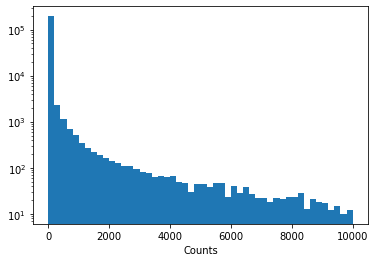

In [ ]:
# Let's see how many words are there for each count

_=plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [ ]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token, count in token_counts.items() if count >= min_count]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [ ]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [ ]:
token_to_id = dict()
for i, word in enumerate(tokens):
  token_to_id[word] = i

In [ ]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [ ]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [ ]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[    2     3     4     1     1]
 [  548  2361     1     1     1]
 [  537 10662   390   307    32]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [ ]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
               sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [ ]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

In [ ]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [ ]:
generate_batch(data_train, 3, max_len=10)

{'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'FullDescription': array([[   35,   105,   183,  2362,    19,    44,   418,    23,   896,
            34],
        [  158,    19,    44,  1752, 10185,   323,    15,    65,   103,
           143],
        [   44,   266,   185,    14,    49, 12955,   814,  3069,    44,
           537]], dtype=int32),
 'Log1pSalary': array([10.736419, 10.021315, 10.768506], dtype=float32),
 'Title': array([[368, 896],
        [544,   4],
        [544,   4]], dtype=int32)}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [ ]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        Layer = self.conv1(h)
        Layer = self.pool1(Layer)
        Layer = F.relu(Layer)
        Layer = self.dense(Layer)

        return Layer

In [ ]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [ ]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
DescEncoder = TitleEncoder

In [ ]:
desc_encoder = DescEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__ Task 2.2__ Build one network ~~to rule them all~~

In [ ]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescEncoder(out_size = 64)
        
        # define layers for categorical features. A few dense layers would do.
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 64)
        )
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.mixed_output = nn.Sequential(
            nn.Linear(192, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 1)
        )
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.categorical_encoder(cat_features)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        result = self.mixed_output(joint_h)
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return result[:, 0]

In [ ]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"]))
desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
reference = Variable(torch.FloatTensor(batch[target_column]))

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [ ]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [ ]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [ ]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [ ]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [ ]:
for epoch_i in range(num_epochs):
    
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy()
        train_mae += compute_mae(reference, prediction).data.numpy()
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    with torch.no_grad():
        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = Variable(torch.LongTensor(batch["Title"]))
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
            cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
            reference = Variable(torch.FloatTensor(batch[target_column]))

            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.data.numpy()
            val_mae += compute_mae(reference, prediction).data.numpy()
            val_batches += 1

    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

Training:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	9.98122
	MAE:	17272.75856



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.99408
	MAE:	8922.60733



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.78439
	MAE:	10084.04650



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.99548
	MAE:	7436.59143



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.67018
	MAE:	9092.05935



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.65704
	MAE:	8902.08708



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.61212
	MAE:	8705.82501



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.92651
	MAE:	6968.28808



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.53727
	MAE:	7916.15402



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.52583
	MAE:	9596.11312



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.52087
	MAE:	7826.23027



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.76072
	MAE:	6751.67967



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.43824
	MAE:	6903.07961



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.36219
	MAE:	6358.43179



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.41900
	MAE:	6684.79629



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.59073
	MAE:	10522.77168



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.40883
	MAE:	6743.49333



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	1.17492
	MAE:	7351.14408



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.39066
	MAE:	6470.86830



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.37441
	MAE:	5268.74784



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.32481
	MAE:	5866.36683



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.30803
	MAE:	4984.78521



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.33405
	MAE:	5835.17644



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.30590
	MAE:	5260.81597



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.29208
	MAE:	5564.24282



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.87436
	MAE:	6932.28787



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.26440
	MAE:	5202.71160



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.41542
	MAE:	5351.33505



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.28522
	MAE:	5467.38325



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.24447
	MAE:	5327.25762



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.24476
	MAE:	5034.47713



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.19624
	MAE:	4364.14120



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.27294
	MAE:	5221.99313



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.20147
	MAE:	4402.69847



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.24998
	MAE:	5096.08718



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.61714
	MAE:	6323.06730



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.23320
	MAE:	4726.09740



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.23184
	MAE:	4318.78972



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.23914
	MAE:	4841.34064



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.18443
	MAE:	4132.00845



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.25696
	MAE:	5101.44465



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.46941
	MAE:	5510.94576



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.23512
	MAE:	4780.07372



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.18126
	MAE:	4177.46242



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.21854
	MAE:	4692.60832



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.17207
	MAE:	4210.18302



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.20906
	MAE:	4714.36552



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.42208
	MAE:	5509.21538



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.22853
	MAE:	4726.77004



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.33980
	MAE:	4955.65043



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.21363
	MAE:	4668.44951



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.26141
	MAE:	4467.25665



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.20411
	MAE:	4551.20760



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.16466
	MAE:	4093.20333



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.20969
	MAE:	4481.10788



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.15601
	MAE:	3763.70290



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.19067
	MAE:	4271.81650



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.17194
	MAE:	3882.85429



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.21838
	MAE:	4546.57493



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.22009
	MAE:	4849.62854



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.20794
	MAE:	4495.56729



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.25536
	MAE:	4431.26828



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.19650
	MAE:	4474.30964



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.25889
	MAE:	4538.41278



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.22879
	MAE:	4772.20411



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.17918
	MAE:	4631.47196



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.19741
	MAE:	4418.71083



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.16355
	MAE:	4042.60514



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.17787
	MAE:	4062.12427



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.24045
	MAE:	4383.25200



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.18032
	MAE:	4173.70888



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.34200
	MAE:	7939.89404



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.18582
	MAE:	4200.78289



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.19144
	MAE:	3975.70034



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.21124
	MAE:	4653.76145



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.19248
	MAE:	3972.88297



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.18519
	MAE:	4280.53451



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.27876
	MAE:	4698.43861



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.19277
	MAE:	4307.16611



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.18859
	MAE:	3933.22174



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.18002
	MAE:	4247.55481



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.55312
	MAE:	6159.01875



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.18208
	MAE:	4150.99653



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.34521
	MAE:	5119.37428



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.19192
	MAE:	4245.11607



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.22892
	MAE:	4339.56542



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.18431
	MAE:	4242.17855



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.23448
	MAE:	4231.70390



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.15871
	MAE:	4030.36179



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.15164
	MAE:	3591.53723



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.15577
	MAE:	3829.34819



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.17933
	MAE:	3821.21930



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.16414
	MAE:	4081.04911



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.14546
	MAE:	3566.63907



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.14584
	MAE:	3743.42302



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.27593
	MAE:	6758.05122



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.16025
	MAE:	3965.27687



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11740
	MAE:	3350.16553



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.17814
	MAE:	4218.61822



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13778
	MAE:	3495.41310



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.17212
	MAE:	3982.15623



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13140
	MAE:	3672.32139



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.15699
	MAE:	4010.02594



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13603
	MAE:	3448.67378



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.15739
	MAE:	3843.93824



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.19281
	MAE:	3888.42579



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13894
	MAE:	3692.68876



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.16281
	MAE:	4496.83592



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13395
	MAE:	3483.73402



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.40839
	MAE:	5617.98003



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.14897
	MAE:	3879.08501



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10468
	MAE:	3169.45470



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.14315
	MAE:	3797.36721



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.16599
	MAE:	3737.39324



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.14349
	MAE:	3750.65371



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.18629
	MAE:	3994.32348



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.19512
	MAE:	4466.70959



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13340
	MAE:	3772.27748



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.16869
	MAE:	4088.15723



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11341
	MAE:	3445.33258



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.14756
	MAE:	3854.90108



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12197
	MAE:	3321.26465



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.15409
	MAE:	3826.30619



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.15840
	MAE:	3733.23113



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.14283
	MAE:	3713.39437



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12355
	MAE:	3492.56319



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.14291
	MAE:	3711.33948



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.14977
	MAE:	3625.24978



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.14756
	MAE:	3777.08112



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.17474
	MAE:	3820.52109



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.18544
	MAE:	4081.62861



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.49973
	MAE:	5788.15988



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.15667
	MAE:	3903.27051



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.22308
	MAE:	4142.14981



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12556
	MAE:	3439.03828



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12365
	MAE:	3346.08664



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13946
	MAE:	3726.41239



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.45135
	MAE:	5784.27893



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13789
	MAE:	3579.73045



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.19433
	MAE:	4033.11772



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.15732
	MAE:	3837.74231



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.24004
	MAE:	4256.27687



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.14320
	MAE:	3697.92468



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.32550
	MAE:	5163.29912



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.14267
	MAE:	3731.06704



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.15351
	MAE:	3605.60574



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.14904
	MAE:	3951.94744



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10014
	MAE:	3107.89664



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.14579
	MAE:	3833.70486



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.35278
	MAE:	5291.44704



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12419
	MAE:	3442.75357



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.16833
	MAE:	3807.73435



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11867
	MAE:	3393.12935



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12357
	MAE:	3318.37040



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.14449
	MAE:	3711.66635



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09524
	MAE:	2932.62020



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12553
	MAE:	3490.48994



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10987
	MAE:	3408.34420



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13726
	MAE:	3651.68279



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13369
	MAE:	3377.49235



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12410
	MAE:	3435.87633



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.14315
	MAE:	3588.55887



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12727
	MAE:	3529.23197



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13704
	MAE:	3465.05010



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12852
	MAE:	3536.68008



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10038
	MAE:	3147.47493



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12623
	MAE:	3442.44062



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11650
	MAE:	3309.36291



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11241
	MAE:	3336.38005



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.16314
	MAE:	3785.86828



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13090
	MAE:	3621.25793



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10287
	MAE:	3255.95065



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12489
	MAE:	3500.72853



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.21314
	MAE:	4114.04147



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13861
	MAE:	3626.63112



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.26905
	MAE:	4569.08974



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13429
	MAE:	3590.61713



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.20448
	MAE:	3991.71285



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12996
	MAE:	3499.46766



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.28745
	MAE:	4777.71006



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12597
	MAE:	3507.74706



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13373
	MAE:	3430.30380



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13279
	MAE:	3545.53443



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.17336
	MAE:	3844.96551



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11810
	MAE:	3353.56375



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10622
	MAE:	3190.95165



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11741
	MAE:	3322.90608



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.34723
	MAE:	5418.39885



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11725
	MAE:	3337.79083



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10197
	MAE:	2976.98019



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.15354
	MAE:	3744.71864



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.25753
	MAE:	6763.89391



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12037
	MAE:	3436.50338



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08598
	MAE:	2822.86792



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11330
	MAE:	3202.00324



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.17809
	MAE:	3659.00745



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10812
	MAE:	3215.97385



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12613
	MAE:	3335.53206



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10514
	MAE:	3099.96325



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11878
	MAE:	3673.60900





In [ ]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

with torch.no_grad():
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.numpy()
        val_mae += compute_mae(reference, prediction).data.numpy()
        val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11878
	MAE:	3673.60900





### Task 3.2: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

Model With More Layer

In [ ]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescEncoder(out_size = 64)
        
        # define layers for categorical features. A few dense layers would do.
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(64, 64),
        )
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.mixed_output = nn.Sequential(
            nn.Linear(192, 1024),
            nn.BatchNorm1d(num_features=1024),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1024, 512),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.BatchNorm1d(num_features=64),
            nn.Dropout(),
            nn.ReLU(),   
            nn.Linear(64, 1),     
        )
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.categorical_encoder(cat_features)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        result = self.mixed_output(joint_h)
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return result[:, 0]

In [ ]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
num_epochs = 30
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [ ]:
for epoch_i in range(num_epochs):
    
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy()
        train_mae += compute_mae(reference, prediction).data.numpy()
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    with torch.no_grad():
        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = Variable(torch.LongTensor(batch["Title"]))
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
            cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
            reference = Variable(torch.FloatTensor(batch[target_column]))

            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.data.numpy()
            val_mae += compute_mae(reference, prediction).data.numpy()
            val_batches += 1

    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

Training:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	79.44944
	MAE:	12549.85964



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	69.16691
	MAE:	12521.16457



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	34.54924
	MAE:	12511.38550



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	38.04733
	MAE:	12495.11120



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	10.80857
	MAE:	17487.44818



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	12.60741
	MAE:	12019.98671



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	6.03040
	MAE:	94533.89441



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	13.99228
	MAE:	12127.36053



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	5.57964
	MAE:	165412.95432



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	10.32951
	MAE:	11612.95353



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	5.22505
	MAE:	114966.83021



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	2.62501
	MAE:	9591.27685



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	4.84409
	MAE:	99833.18205



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	2.48128
	MAE:	9979.04493



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	4.63340
	MAE:	109992.72771



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	2.16942
	MAE:	9314.34142



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	4.31592
	MAE:	87117.92314



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	2.18688
	MAE:	9243.01833



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	4.07615
	MAE:	65125.79660



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	1.06550
	MAE:	8861.25381



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	4.06132
	MAE:	73626.56128



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	1.27726
	MAE:	8776.01883



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	4.02269
	MAE:	67415.82264



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	1.04761
	MAE:	7706.80530



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	3.87176
	MAE:	48090.85271



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	1.06575
	MAE:	7593.38546



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	3.70846
	MAE:	59329.78717



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	1.01401
	MAE:	7672.18952



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	3.53819
	MAE:	54641.80115



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.92706
	MAE:	7508.15430



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	3.41464
	MAE:	42371.56906



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	1.07775
	MAE:	8113.67914



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	3.44453
	MAE:	40154.41785



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	1.31402
	MAE:	7602.57186



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	3.27567
	MAE:	37572.48529



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.92737
	MAE:	7089.04391



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	3.18639
	MAE:	41282.29119



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.66613
	MAE:	7476.71673



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	3.08972
	MAE:	35778.17861



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	1.21581
	MAE:	8105.32859



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	3.04983
	MAE:	32524.12803



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.62475
	MAE:	6363.32340



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	2.96784
	MAE:	37701.78313



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.56224
	MAE:	6762.44347



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	2.93871
	MAE:	32621.96514



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.84713
	MAE:	7327.79147



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	2.93652
	MAE:	32902.63571



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.64767
	MAE:	6586.50090



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	2.84275
	MAE:	30155.22966



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.46750
	MAE:	6024.82920



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	2.81714
	MAE:	30454.71411



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.47818
	MAE:	6074.06633



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	2.82739
	MAE:	30679.32269



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.67704
	MAE:	6419.09918



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	2.57062
	MAE:	26241.44389



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.61136
	MAE:	6215.74085



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	2.73688
	MAE:	31740.78937



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.43748
	MAE:	5644.22509



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	2.69290
	MAE:	29684.61162



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.62079
	MAE:	6296.25153





In [ ]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

with torch.no_grad():
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.numpy()
        val_mae += compute_mae(reference, prediction).data.numpy()
        val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.62079
	MAE:	6296.25153





### A short report

Please tell us what you did and how did it work.

In assignment 2:

  * I defined a network with a 2 Linear layer + BatchNorm1D + an activation layer for categorical features

  * I applied 2 Linear layer + BatchNorm1D + an activation layer for out put

  The model obtained MAE = 3673 for final assess

In assignment 3:

  * I did the experiment for shorter epoch for accelerating the experiment

  * I tried to add more layer, Dropout, more BatchNorm1d, more Linear, more activation

  * For categorical feature I applied 4 Linear layer + 3 BatchNorm1d + 3 avtivation layer (ReLU) + 3 Dropout

  * For output part I added 4 Linear layer + 2 BatchNorm1d + 3 avtivation layer (ReLU) + 3 Dropout

  The model obtained MAE = 6296 for final assess.